# Style Transfer TAREA

## Eduardo Manuel Ceja Cruz

In [1]:
import random
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage

import fastai.vision.all as fv
from fastai.callback.hook import hook_outputs

from fastprogress.fastprogress import progress_bar

## Las cosas para el proprocesamiento

In [2]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]): #stats de Image Net
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std  = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

In [3]:
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

In [4]:
to_pil = ToPILImage()
to_tensor = ToTensor()

In [5]:
def denorm(t):
    mean,sd = (torch.tensor(x) for x in fv.imagenet_stats)
    mean,sd = mean[:,None,None],sd[:,None,None]
    return mean + t*sd

def view(t):
    t = t.detach().cpu()
    if len(t.shape) == 4:
        t = t[0]
    return to_pil(denorm(t).clamp(0,1))

## Las imagenes que vamos a usar

In [6]:
size = (384,256)
# size = (256, 384)

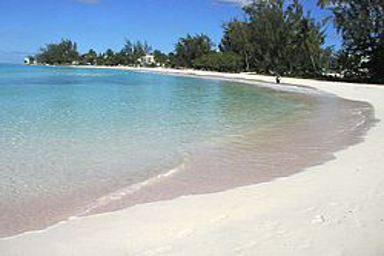

In [7]:
content_img = fv.PILImage.create("playa.jpg").resize(size)
content_img

In [8]:
content_tensor = Normalizer()(to_tensor(content_img)[None])

In [9]:
content_tensor.shape

torch.Size([1, 3, 256, 384])

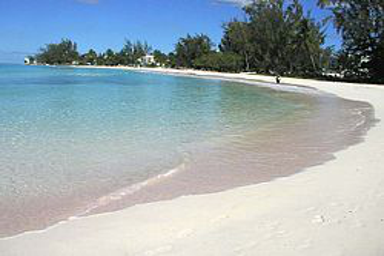

In [10]:
view(content_tensor)

In [11]:
content_tensor = content_tensor.cuda()

In [12]:
noise = torch.randn_like(content_tensor, requires_grad = True)

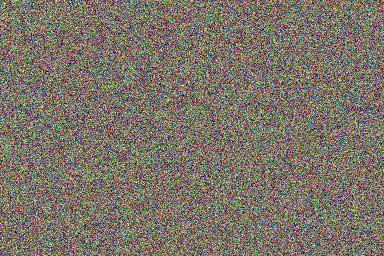

In [13]:
view(noise)

In [14]:
optimizer = torch.optim.Adam([noise], lr = 1e-1)

In [15]:
pbar = progress_bar(range(3000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = F.mse_loss(noise, content_tensor)
    pbar.comment = f"loss = {loss.item()}"
    loss.backward()
    optimizer.step()

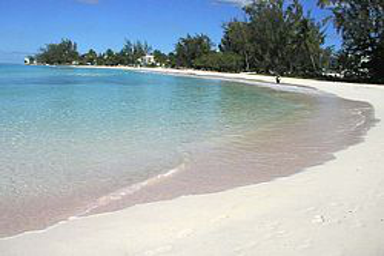

In [16]:
view(noise)

## Agregando el Estilo

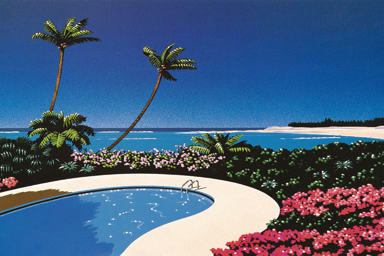

In [17]:
style = fv.PILImage.create("nagai hiroshi.jpg").resize(size)
# style = fv.PILImage.create("tsumugi.jpg")
style

In [18]:
style_tensor = Normalizer()(to_tensor(style)).cuda()
style_tensor

tensor([[[[-1.1247, -1.1760, -1.1075,  ..., -1.5185, -1.5870, -1.5185],
          [-1.1932, -1.2445, -1.2103,  ..., -1.5870, -1.6213, -1.5014],
          [-1.2445, -1.2959, -1.1418,  ..., -1.6042, -1.6555, -1.6555],
          ...,
          [-1.7583, -1.6555, -1.6384,  ..., -0.7993,  1.1872,  1.6153],
          [-1.8782, -1.7240, -1.6727,  ...,  1.1700,  1.7180,  1.7694],
          [-1.7069, -1.7069, -1.7240,  ...,  1.2385,  1.5639,  1.7523]],

         [[-0.6702, -0.6702, -0.6001,  ..., -0.7927, -0.8452, -0.8102],
          [-0.6527, -0.7052, -0.6877,  ..., -0.8627, -0.8277, -0.8978],
          [-0.6702, -0.7227, -0.6352,  ..., -0.8452, -0.8627, -0.8277],
          ...,
          [-0.3375, -0.3901, -0.3375,  ..., -1.2654,  0.2402,  0.7654],
          [-0.3025, -0.3375, -0.3375,  ..., -0.5651,  0.4328,  0.6954],
          [-0.3550, -0.3200, -0.3375,  ..., -0.5301,  0.4853,  0.6429]],

         [[ 0.1825,  0.2348,  0.1825,  ...,  0.1825,  0.2871,  0.2173],
          [ 0.1128,  0.1651,  

## Definimos las cosas para la transferencia de estilo 

In [19]:
def gram_matrix(x):
    bs,c,h,w = x.shape
    x = x.view(bs,c,h*w)
    return (x @ x.transpose(1,2))/(c*h*w)

In [20]:
class StyleAndContentLoss(nn.Module):
    def __init__(self, model, layer_ids, content_weigths = [1,3,8,12,20,10], style_weights = [20,25,15,10,4], style_mult = 8e3):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach = False)
        self.content_weigths = content_weigths
        self.style_weights = style_weights
        self.style_mult = style_mult 
        
    def extract_features(self, x, clone =False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
            
        return features
    
    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a,b,w in zip(A, B, self.content_weigths)])
    
    def style_loss(self, A, B):
        return sum([F.l1_loss(gram_matrix(a), gram_matrix(b))*w for a,b,w in zip (A, B, self.style_weights)])
    
    
    def forward(self, x, content_image,style_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone = True)
        style_features = self.extract_features(style_image, clone = True)
        
        self.CL = self.content_loss(x_features, content_features)
        self.SL = self.style_mult*self.style_loss(x_features, style_features)
        
        return self.CL + self.SL
    
    def __del__(self):
        self.hooks.remove() 

In [21]:
def style_content_loss(**kwargs):
    vgg = fv.vgg16_bn(pretrained = True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    good_blocks = [i for i,x in enumerate(vgg.children()) if type(x) == nn.MaxPool2d]
    
    return StyleAndContentLoss(vgg, layer_ids=good_blocks, **kwargs)

In [22]:
content_and_style_loss = style_content_loss().cuda()

In [23]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [24]:
from datetime import datetime

In [25]:
t1 = datetime.now()
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(noise, content_tensor, style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.2f} | style_loss = {content_and_style_loss.SL:.2f} | total loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()

print(datetime.now() - t1)

0:01:11.367776


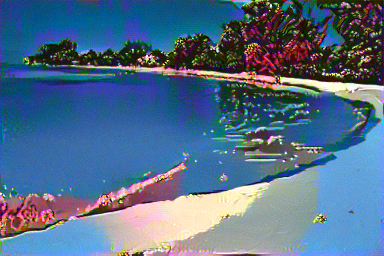

In [26]:
view(noise)

## Version modificada

Primero, regresamos el noise a la imagen original 

In [27]:
noise = torch.randn_like(content_tensor, requires_grad = True)

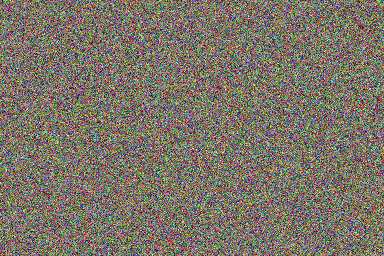

In [28]:
view(noise)

In [29]:
optimizer = torch.optim.Adam([noise], lr = 1e-1)

In [30]:
pbar = progress_bar(range(3000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = F.mse_loss(noise, content_tensor)
    pbar.comment = f"loss = {loss.item()}"
    loss.backward()
    optimizer.step()

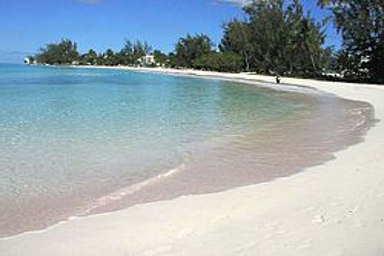

In [31]:
view(noise)

Modificamos la clase

In [32]:
class StyleAndContentLossModificada(nn.Module):
    def __init__(self, model, layer_ids, content_image, style_image ,content_weigths = [1,3,8,12,20,10], style_weights = [20,25,15,10,4], style_mult = 8e3):
        super().__init__()
        self.model = model
        self.model.cuda()
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach = False)
        self.content_weigths = content_weigths
        self.style_weights = style_weights
        self.style_mult = style_mult
        
        self.content_features = self.extract_features(content_image, clone = True)
        self.style_features = self.extract_features(style_image, clone = True)
        
    def extract_features(self, x, clone =False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
            
        return features
    
    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a,b,w in zip(A, B, self.content_weigths)])
    
    def style_loss(self, A, B):
        return sum([F.l1_loss(gram_matrix(a), gram_matrix(b))*w for a,b,w in zip (A, B, self.style_weights)])
    
    
    def forward(self, x, content_image,style_image):
        x_features = self.extract_features(x)
#         content_features = self.extract_features(content_image, clone = True)
#         style_features = self.extract_features(style_image, clone = True)
        
        self.CL = self.content_loss(x_features, self.content_features)
        self.SL = self.style_mult*self.style_loss(x_features, self.style_features)
        
        return self.CL + self.SL
    
    def __del__(self):
        self.hooks.remove() 

In [33]:
def style_content_loss_modificado(**kwargs):
    vgg = fv.vgg16_bn(pretrained = True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    good_blocks = [i for i,x in enumerate(vgg.children()) if type(x) == nn.MaxPool2d]
    
    return StyleAndContentLossModificada(vgg, content_image = content_tensor, style_image = style_tensor,layer_ids=good_blocks, **kwargs)

In [34]:
content_and_style_loss_mod = style_content_loss_modificado().cuda()

In [35]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [36]:
t1 = datetime.now()
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss_mod(noise, content_tensor, style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss_mod.CL:.2f} | style_loss = {content_and_style_loss_mod.SL:.2f} | total loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()
    
print(datetime.now() - t1)

0:00:40.407721


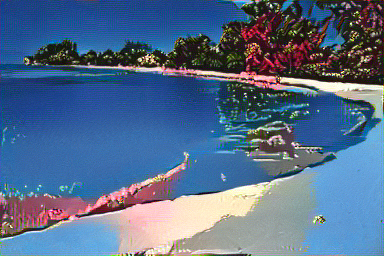

In [37]:
view(noise)

Vemos que el resultado salio parecido y con menor tiempo, mas o menos como la mitad de tiempo o menos. Tuve unos problemas si no le ponia `self.model.cuda()` por alguna razon no lo pasaba, pero de ahi en fuera todo funciono como debia. (El resultado si se ve medio feo pero se ve mejor que otros experimentos con la playa que intente)

## Que pasa si le pongo monas chinas?
### La pregunta del dia

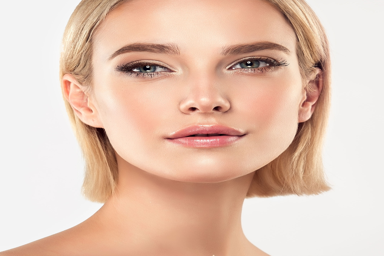

In [38]:
content_img = fv.PILImage.create("face.jpg").resize(size)
content_img

In [39]:
content_tensor = Normalizer()(to_tensor(content_img)[None])

In [40]:
content_tensor = content_tensor.cuda()

In [41]:
noise = torch.randn_like(content_tensor, requires_grad = True)

In [42]:
optimizer = torch.optim.Adam([noise], lr = 1e-1)

In [43]:
pbar = progress_bar(range(3000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = F.mse_loss(noise, content_tensor)
    pbar.comment = f"loss = {loss.item()}"
    loss.backward()
    optimizer.step()

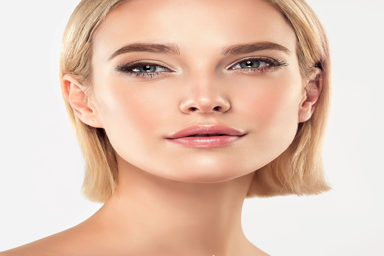

In [44]:
view(noise)

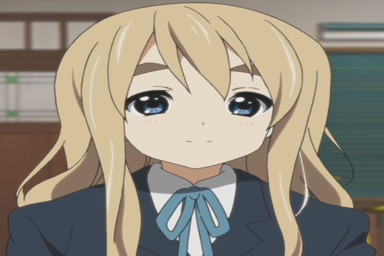

In [45]:
style = fv.PILImage.create("Tsumugi_Kotobuki.png").resize(size)
style

In [46]:
style_tensor = Normalizer()(to_tensor(style)).cuda()
style_tensor

tensor([[[[ 0.0569,  0.0569,  0.0912,  ...,  0.6392,  0.6221,  0.6392],
          [ 0.0569,  0.0569,  0.0912,  ...,  0.6392,  0.6392,  0.6392],
          [ 0.0741,  0.0912,  0.1083,  ...,  0.6563,  0.6563,  0.6563],
          ...,
          [-0.6109, -0.5938, -0.6109,  ..., -0.5424, -0.5424, -0.4911],
          [-0.6109, -0.6109, -0.6281,  ..., -0.5424, -0.5253, -0.4739],
          [-0.6109, -0.5938, -0.6281,  ..., -0.5424, -0.5253, -0.4739]],

         [[ 0.0651,  0.0651,  0.0651,  ...,  0.6604,  0.6429,  0.6604],
          [ 0.0651,  0.0651,  0.0826,  ...,  0.6604,  0.6604,  0.6604],
          [ 0.0651,  0.0651,  0.0826,  ...,  0.6779,  0.6779,  0.6779],
          ...,
          [-0.8978, -0.8978, -0.8803,  ..., -0.7402, -0.7402, -0.7052],
          [-0.8978, -0.8978, -0.8978,  ..., -0.7402, -0.7227, -0.7052],
          [-0.8978, -0.8978, -0.8978,  ..., -0.7402, -0.7402, -0.7052]],

         [[ 0.1476,  0.1476,  0.1476,  ...,  0.7402,  0.7228,  0.7402],
          [ 0.1476,  0.1476,  

In [47]:
content_and_style_loss_mod_monas_chinas = style_content_loss_modificado().cuda()

In [48]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [49]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss_mod_monas_chinas(noise, content_tensor, style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss_mod_monas_chinas.CL:.2f} | style_loss = {content_and_style_loss_mod_monas_chinas.SL:.2f} | total loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()

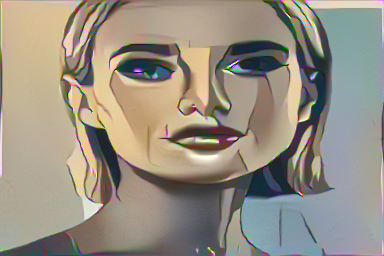

In [50]:
view(noise)

Bueno, no se hizo una buena monita china, pero se ve caritacurezco